# EOF analysis

EOF analysis is performed using the [Eofs](https://ajdawson.github.io/eofs/latest/index.html) package. In the following, the steps for the computation of an EOF decomposition is provided. The objective would be to compute the El Nino index based on the SST of the Northern Pacific.

## Extraction of Pacific mask

The Pacific mask can first be extracted based on coordinates (longitudes and latitudes) as follows:

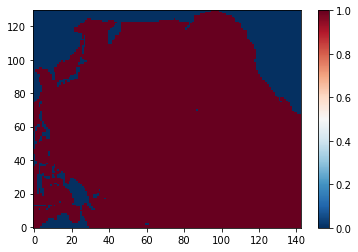

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

data = xr.open_dataset('data/mesh_mask_eORCA1_v2.2.nc')
data = data.isel(z=0, t=0)
lon = data['glamt'].values
lat = data['gphit'].values
mask = data['tmask'].values

# converts lon from Atl to Pac.
lon[lon < 0] += 360

# mask based on latitudes
ilat = (lat <= 60) & (lat >= -20)
mask[~ilat] = 0

# mask based on longitudes
ilon = (lon >= 117 ) & (lon <= 260)
mask[~ilon] = 0

# extracting the domain using the slices
ilat, ilon = np.nonzero(mask == 1)
ilat = slice(ilat.min(), ilat.max() + 1)
ilon = slice(ilon.min(), ilon.max() + 1)
mask = mask[ilat, ilon]

plt.figure()
cs = plt.imshow(mask, interpolation='none')
cb = plt.colorbar(cs)

## Computation of seasonal anomalies

Now, we need to compute the seasonal anomalies of SST fields. First, we read the SST values and extract the spurious `olevel` dimension.

In [2]:
data = xr.open_dataset("data/surface_thetao.nc")
data = data.isel(olevel=0, x=ilon, y=ilat)
ntime = data.dims['time_counter']
data = data['thetao']

Now, we compute the anomalies using the `groupy` methods:

In [3]:
clim = data.groupby('time_counter.month').mean()
anoms = data.groupby('time_counter.month') - clim

## Detrending the time-series

Now that the anomalies have been computed, the linear trend is removed using the `detrend` function. Since the detrend function does not manage NaNs, the filled values are first replaced by 0s 

In [4]:
import scipy.signal as sig
import time

anoms = anoms.fillna(0)
anoms_detrend = sig.detrend(anoms, axis=0)
print(type(anoms_detrend))

<class 'numpy.ndarray'>


Note that in the `detrend` function returns a `numpy.array` object. Hence, no benefit will be taken from the `xarray` structure in the EOF calculation.

## Extracting the weights

Now, the next step is to extract the weights for the EOFs, based on the cell surface and mask.

In [5]:
mesh = xr.open_dataset('data/mesh_mask_eORCA1_v2.2.nc')
mesh = mesh.isel(t=0, x=ilon, y=ilat)
surf = mesh['e1t'] * mesh['e2t']
surf = surf.data * mask  # surf in Pacific, 0 elsewhere
weights = surf / np.sum(surf)  # normalization of weights

**Since EOF are based on covariance, the root-square of the weights must be used.**

In [6]:
weights = np.sqrt(weights)

## Computation of EOFS (standard mode)

The EOFS can now be computed. First, an EOF solver must be initialized. **The `time` dimension must always be the first one when using numpy.array as inputs.**

In [7]:
import eofs
from eofs.standard import Eof

solver = Eof(anoms_detrend, weights=weights)

Now, EOF components can be extracted. First, the covariance maps are extracted.

<class 'numpy.ndarray'>


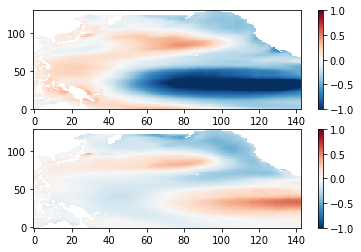

In [8]:
neofs = 2
nlat, nlon = surf.shape
covmaps = solver.eofsAsCovariance(neofs=neofs)
print(type(covmaps))

plt.figure()
plt.subplot(211)
cs = plt.imshow(covmaps[0], cmap=plt.cm.RdBu_r)
cs.set_clim(-1, 1)
cb = plt.colorbar(cs)
plt.subplot(212)
cs = plt.imshow(covmaps[1], cmap=plt.cm.RdBu_r)
cs.set_clim(-1, 1)
cb = plt.colorbar(cs)

Then, we can recover the explained variance:

In [9]:
eofvar = solver.varianceFraction(neigs=neofs) * 100
eofvar

array([32.90275273,  7.66532732])

Finally, we can obtain the principal components. To obtain normalized time-series, the `pscaling` argument must be equal to 1.

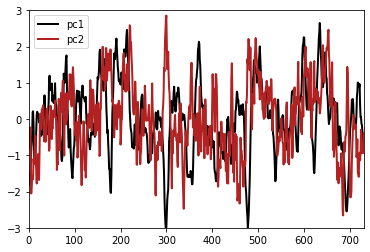

In [10]:
pcs = solver.pcs(pcscaling=1, npcs=neofs).T
plt.figure()
plt.plot(pcs[0], label='pc1')
plt.plot(pcs[1], label='pc2')
leg = plt.legend()
plt.gca().set_ylim(-3, 3)
plt.gca().set_xlim(0, len(pcs[0]) - 1) 
plt.savefig('ts1')

## EOF computation (xarray mode)

In order to have EOF as an `xarray` with all its features, the Eof method of the `eofs.xarray` submodule must be used.

In [11]:
from eofs.xarray import Eof

Since it uses named labels, the `time_counter` dimension must first be renamed in `time`:

In [12]:
anoms = anoms.rename({'time_counter': 'time'})
anoms

<xarray.DataArray 'thetao' (time: 732, y: 130, x: 143)>
array([[[-0.31064034, -0.43762016, -0.6249218 , ..., -0.15113449,
         -0.14532661, -0.12656021],
        [-0.58628273, -0.527586  , -0.51573753, ..., -0.17450714,
         -0.16910744, -0.16069221],
        [-0.50172234, -0.5104065 , -0.45276833, ..., -0.22327042,
         -0.2349453 , -0.24970245],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.01728249, -0.38983345, -0.48926353, ..., -0.6211891 ,
         -0.5961971 , -0.57370186],
        [ 0.22153282,  0.18938446,  0.04576683, ..., -0.6281853 ,
         -0.6296387 , -0.6185684 ],
        [ 0.43194962,  0.39792442,  0.34593582, ..., -0.63476753,
         -0.68650436, -0.66425705],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.4598808 , -1.3692341 , -1.0059109 , ...,  0.25130844,
          0.290699  ,  0.33873367],
        [-1.3499966 , -1.3351994 , -1.1092415 , ...,  0.1412735 ,
          0.18891907,  0.23643875],
        [-1.2326813 , -1.1757793 , -1.0902805 , ...,  0.02304268,
          0.05507469,  0.06399536],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
    nav_lat        (y, x) float32 -19.61 -19.61 -19.61 ... 55.74 55.78 55.82
    nav_lon        (y, x) float32 117.5 118.5 119.5 ... -103.1 -102.3 -101.4
    olevel         float32 0.5058
    time_centered  (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * time           (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

To make sure it works, coordinate variables need to be removed.

In [13]:
anoms = anoms.drop_vars(['nav_lat', 'nav_lon', 'time_centered', 'month'])
anoms

<xarray.DataArray 'thetao' (time: 732, y: 130, x: 143)>
array([[[-0.31064034, -0.43762016, -0.6249218 , ..., -0.15113449,
         -0.14532661, -0.12656021],
        [-0.58628273, -0.527586  , -0.51573753, ..., -0.17450714,
         -0.16910744, -0.16069221],
        [-0.50172234, -0.5104065 , -0.45276833, ..., -0.22327042,
         -0.2349453 , -0.24970245],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.01728249, -0.38983345, -0.48926353, ..., -0.6211891 ,
         -0.5961971 , -0.57370186],
        [ 0.22153282,  0.18938446,  0.04576683, ..., -0.6281853 ,
         -0.6296387 , -0.6185684 ],
        [ 0.43194962,  0.39792442,  0.34593582, ..., -0.63476753,
         -0.68650436, -0.66425705],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.4598808 , -1.3692341 , -1.0059109 , ...,  0.25130844,
          0.290699  ,  0.33873367],
        [-1.3499966 , -1.3351994 , -1.1092415 , ...,  0.1412735 ,
          0.18891907,  0.23643875],
        [-1.2326813 , -1.1757793 , -1.0902805 , ...,  0.02304268,
          0.05507469,  0.06399536],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
    olevel   float32 0.5058
  * time     (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
Dimensions without coordinates: y, x

In [14]:
solver = Eof(anoms, weights=weights)

In [15]:
neofs = 2
covmaps = solver.eofsAsCovariance(neofs=neofs)
covmaps

<xarray.DataArray 'eofs' (mode: 2, y: 130, x: 143)>
array([[[ 0.10379874,  0.10604983,  0.06451281, ..., -0.350463  ,
         -0.3487487 , -0.3477348 ],
        [ 0.04711282,  0.03726971,  0.01815447, ..., -0.36571452,
         -0.36313176, -0.3593843 ],
        [ 0.01782429,  0.01496945,  0.00708527, ..., -0.3726195 ,
         -0.36914334, -0.36383352],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.11388557, -0.12287213, -0.13214622, ...,  0.00338123,
          0.00419892,  0.00579085],
        [-0.11459833, -0.12700635, -0.13634968, ...,  0.01180524,
          0.01197228,  0.01189382],
        [-0.11706407, -0.12831454, -0.13485081, ...,  0.01716777,
          0.01456021,  0.01296214],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 121 122 123 124 125 126 127 128 129
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 134 135 136 137 138 139 140 141 142
Attributes:
    long_name:  covariance_between_pcs_and_thetao

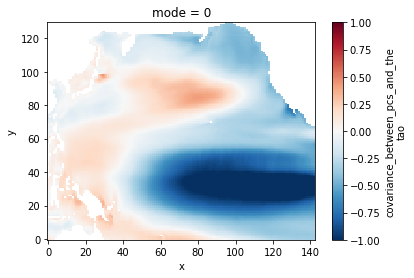

In [16]:
plt.figure()
cs = covmaps.isel(mode=0).plot()
cs.set_clim(-1, 1)

In [17]:
pcs = solver.pcs(pcscaling=1, npcs=neofs)
pcs

<xarray.DataArray 'pcs' (time: 732, mode: 2)>
array([[-1.0939478 , -0.23894596],
       [-1.1724232 , -0.3829829 ],
       [-1.382449  , -0.14822622],
       ...,
       [-1.2102919 , -1.6217964 ],
       [-1.3049158 , -1.6621873 ],
       [-1.1621714 , -1.2294388 ]], dtype=float32)
Coordinates:
  * time     (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * mode     (mode) int64 0 1

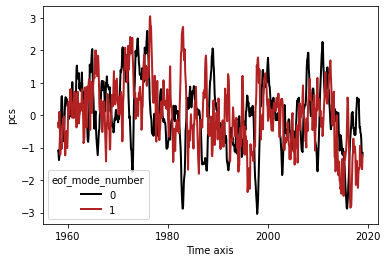

In [18]:
plt.figure()
l = pcs.plot.line(x='time')
plt.savefig('ts2')